In [2]:
library(ggplot2)
library(ChIPseeker)
library(GenomicFeatures)
library(tidyverse)
library(ggvenn)
library(cowplot)
library(patchwork)
library(ggsci)
library(ggplotify)
library(clusterProfiler)
library(readxl)
library(DESeq2)
library(ggrepel)
library(ggupset)
library(ClusterGVis)
library(edgeR)
library(Mfuzz)
library(ComplexHeatmap)
library(maSigPro)

In [3]:
load("06_counts/DEGs.RData")

In [4]:
DEGs <- DEGs %>%
    dplyr::filter(group!="None")

In [5]:
count <- read.table("06_counts/Loquat_ZP.counts",header=T,check.names=F)

In [6]:
count <- count %>%
    dplyr::select(-c(Chr,Start,End,Strand,Length)) %>%
    dplyr::filter(Geneid %in% DEGs$gene)

In [7]:
count %>%
    dplyr::filter(Geneid=='EVM0010743') ->ll

In [8]:
rownames(count) <- count$Geneid
count <- count[,-1]

In [9]:
expr <- log2(edgeR::cpm(count)+1)

In [10]:
expr <- t(expr)
rownames(expr) <- gsub('_\\d+','',rownames(expr))

In [11]:
expr <- limma::avereps(expr)

In [12]:
set.seed(123)
zp <- clusterData(obj = t(expr),
                  cluster.method = "mfuzz",
                  min.std = 0.3,
                  cluster.num = 8,
                 seed =123)

[1] "26 genes excluded.\n"


In [13]:
mycolor <- c('#E64B35B2','RoyalBlue4','#00A087B2','#3C5488B2','PaleVioletRed3',"IndianRed4","tan1","#6B8E23")

In [14]:
KOannotation <- read.delim("GO/SS_GOannotation.tsv", stringsAsFactors=FALSE)
genes <- lapply(KOannotation$gene,function(x){
    gene <- unlist(str_split(x,"\\."))[1]
    }
    )
KOannotation$gene <- unlist(genes)
KOinfo <- read.delim("GO//go.tb", stringsAsFactors=FALSE)
KOannotation = split(KOannotation, with(KOannotation, level))
KOkegg <- read.delim("KEGG/SS_KOannotation.tsv", stringsAsFactors=FALSE)
genes <- lapply(KOkegg$gene,function(x){
    gene <- unlist(str_split(x,"\\."))[1]
    }
    )
KOkegg$gene <- unlist(genes)

In [28]:
KEGG_result <- NULL
GO_result <- NULL
for(cluster in 1:8){
    genes <- zp$cluster[[cluster]]
    for(j in c("biological_process","cellular_component","molecular_function")){
        print(j)
        ego <- enricher(genes,TERM2GENE=KOannotation[[j]][c(2,1)],TERM2NAME=KOinfo[1:2])
        ego <- data.frame(ego)
        ego <- ego[ego$p.adjust<0.05,]
        if(nrow(ego)==0){
            next
        }
        if(nrow(ego)>=5){
                ego <- ego[1:5,]
        }
        ego$ONTOLOGY <- j 
        GeneRatio <- lapply(ego$GeneRatio,function(x){
            x <- as.numeric(unlist(str_split(x,"/")))
            r <- x[1]/x[2]
        })
        ego$Ratio <- unlist(GeneRatio)
        ego <- ego %>%
                    arrange(Ratio) %>%
                mutate(cluster=cluster)
        GO_result <- rbind(GO_result,ego)
    }
    
    kegg <- enricher(genes,TERM2GENE=KOkegg[c(3,1)],TERM2NAME=KOkegg[c(3,4)])
    kegg <- data.frame(kegg)
    kegg <- kegg[kegg$p.adjust<0.05,]
    if(nrow(kegg)==0){
        next
    }
    kegg$ONTOLOGY <- "KEGG" 
    generatio <- lapply(kegg$GeneRatio,function(x){
                x <- as.numeric(unlist(str_split(x,"/")))
                r <- x[1]/x[2]
            })
    kegg$Ratio <- unlist(generatio)
    if(nrow(kegg)>=5){
            kegg <- kegg[1:5,]
    }
    kegg <- kegg %>%
                arrange(Ratio) %>%
                mutate(cluster=cluster)
    KEGG_result <- rbind(KEGG_result,kegg)
}

[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"
[1] "biological_process"
[1] "cellular_component"
[1] "molecular_function"


In [23]:
KEGG_result2 <- KEGG_result %>%
    dplyr::select(group=cluster,Description,pvalue) %>%
    mutate(group=paste0('C',group))
GO_result2 <- GO_result %>%
    dplyr::select(group=cluster,Description,pvalue) %>%
    mutate(group=paste0('C',group))

In [17]:
#write.csv(GO_result2,"07_enrich/GO.csv",row.names=F)

In [18]:
GO_result2 <- read.csv("07_enrich//GO.csv")

In [19]:
data <- zp$long.res %>%
    mutate(Stage=str_extract(cell_type,"-(\\w+)")) %>%
    mutate(Stage=gsub("-","",Stage)) %>%
    mutate(Loquat=str_extract(cell_type,"(\\w+)-")) %>%
    mutate(Loquat=gsub("-","",Loquat))

`summarise()` has grouped output by 'cluster', 'Loquat'. You can override using the `.groups` argument.
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


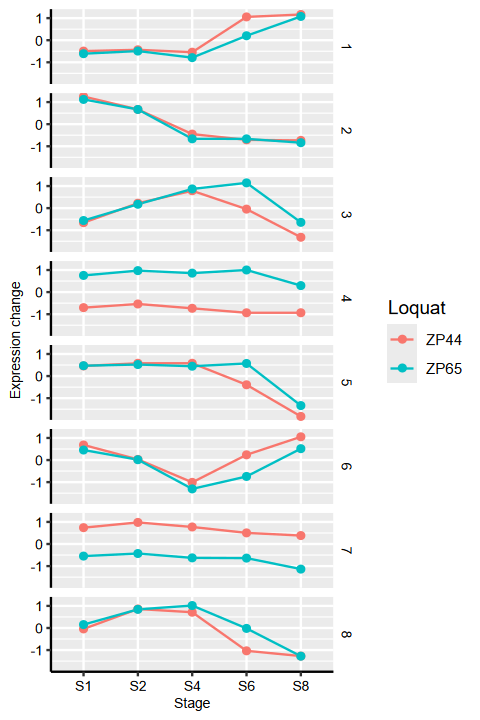

In [20]:
options(repr.plot.width=4, repr.plot.height=6)
Figure4A <- data %>%
    group_by(cluster,Loquat,Stage) %>%
    summarise(norm_value=median(norm_value)) %>%
    ggplot(aes(Stage,norm_value,group=Loquat,color=Loquat))+
        geom_line()+
        geom_point()+
    facet_grid(cluster~.)+
    theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
               axis.text.x = element_text(angle=0),
              legend.position='right',strip.text = element_text(size = 8, colour = "black"),
              strip.background = element_rect(color="white",fill='white'),
             axis.line = element_line(colour = "black",size = 0.5))+
    ylab("Expression change")
Figure4A

In [17]:
#pdf("Figures\\Figure 4A.pdf",width=4,height=6)
#Figure4A
#dev.off()

pdf 
  2

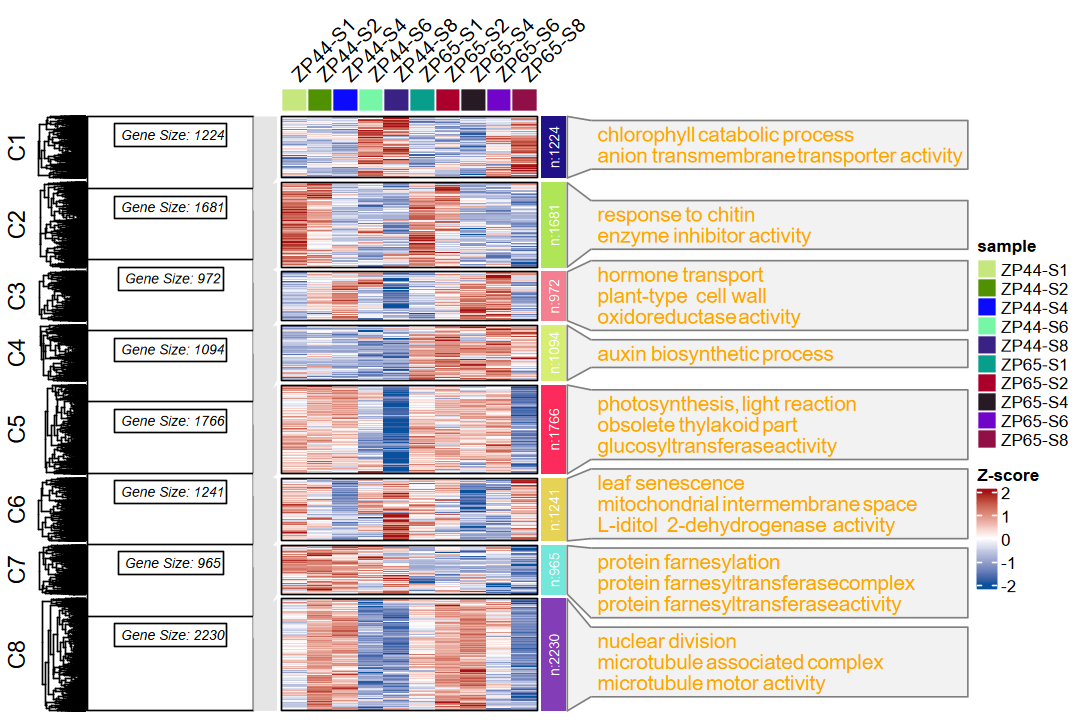

In [68]:
options(repr.plot.width=9, repr.plot.height=6)
Figure4B <- visCluster(object = zp,
           plot.type = "both",
           column_names_rot = 45,
           add.box = F,go.col='orange',
           add.line = F,
           boxcol = ggsci::pal_npg()(8),
           line.side = "left",annoTerm.data=GO_result2,
           cluster.order = c(1:8))
Figure4B

In [73]:
#pdf("Figures\\Figure 4B.pdf",width=9,height=6)
#Figure4B
#dev.off()

pdf 
  2

In [33]:
auxin <- c("EVM0040814","EVM0024713","EVM0022504","EVM0016915","EVM0024929","EVM0038180","EVM0043264","EVM0028031","EVM0037527","EVM0003783","EVM0008001","EVM0001937","EVM0020857","EVM0017498","EVM0027400","EVM0001616","EVM0002461","EVM0004175","EVM0042677","EVM0027362","EVM0041302","EVM0043467","EVM0019912","EVM0001900","EVM0022312","EVM0012222","EVM0011012","EVM0000886","EVM0036289","EVM0040487","EVM0026840","EVM0006053","EVM0026629","EVM0031635","EVM0038220","EVM0009205","EVM0034009","EVM0037117","EVM0007610","EVM0018623","EVM0043502","EVM0001357","EVM0020538","EVM0003176","EVM0012056","EVM0019672","EVM0019397","EVM0005286","EVM0039242","EVM0035364","EVM0017201","EVM0010783","EVM0000173","EVM0025167")

In [36]:
ll <- c("EVM0002466","EVM0003403","EVM0006013","EVM0006871","EVM0012222","EVM0016403","EVM0017866","EVM0022396","EVM0025330","EVM0030632","EVM0033810","EVM0034832","EVM0043514","EVM0044174","EVM0008360","EVM0009202","EVM0009281","EVM0009692","EVM0010301","EVM0011358","EVM0020537","EVM0025660")

In [37]:
intersect(auxin,ll)

[1] "EVM0012222"

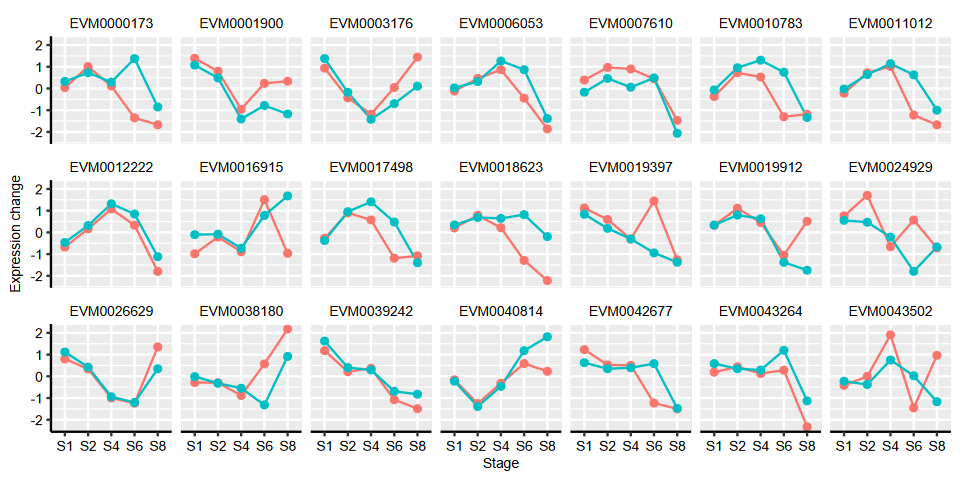

In [39]:
options(repr.plot.width=8, repr.plot.height=4)
FigureS4 <- data %>%
    dplyr::filter(gene %in% auxin) %>%
    ggplot(aes(Stage,norm_value,group=Loquat,color=Loquat))+
        geom_line()+
        geom_point()+
    facet_wrap(~gene,ncol=7)+
    theme(axis.text=element_text(size=8,color='black'),
              axis.title=element_text(size=8),
               axis.text.x = element_text(angle=0),
              legend.position='none',strip.text = element_text(size = 8, colour = "black"),
              strip.background = element_rect(color="white",fill='white'),
             axis.line = element_line(colour = "black",size = 0.5))+
    ylab("Expression change")
FigureS4

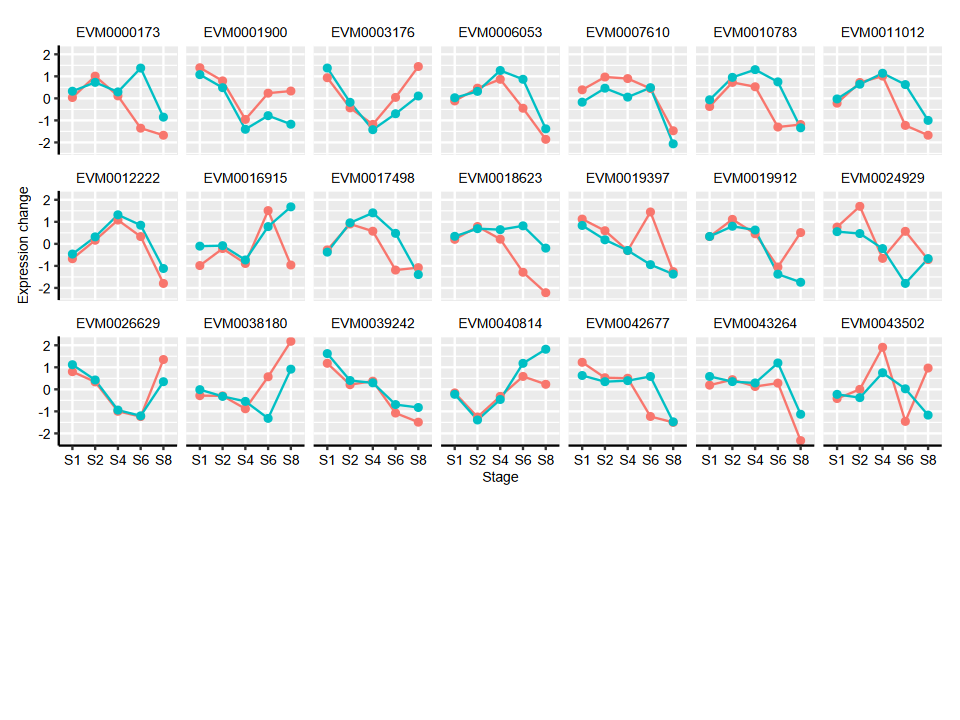

In [40]:
options(repr.plot.width=8, repr.plot.height=6)
((FigureS4/plot_spacer())+plot_layout(height=c(2,1)))

In [42]:
#pdf("Figures\\Figure S4.pdf",width=8,height=6)
#((FigureS4/plot_spacer())+plot_layout(height=c(2,1)))
#dev.off()

pdf 
  2

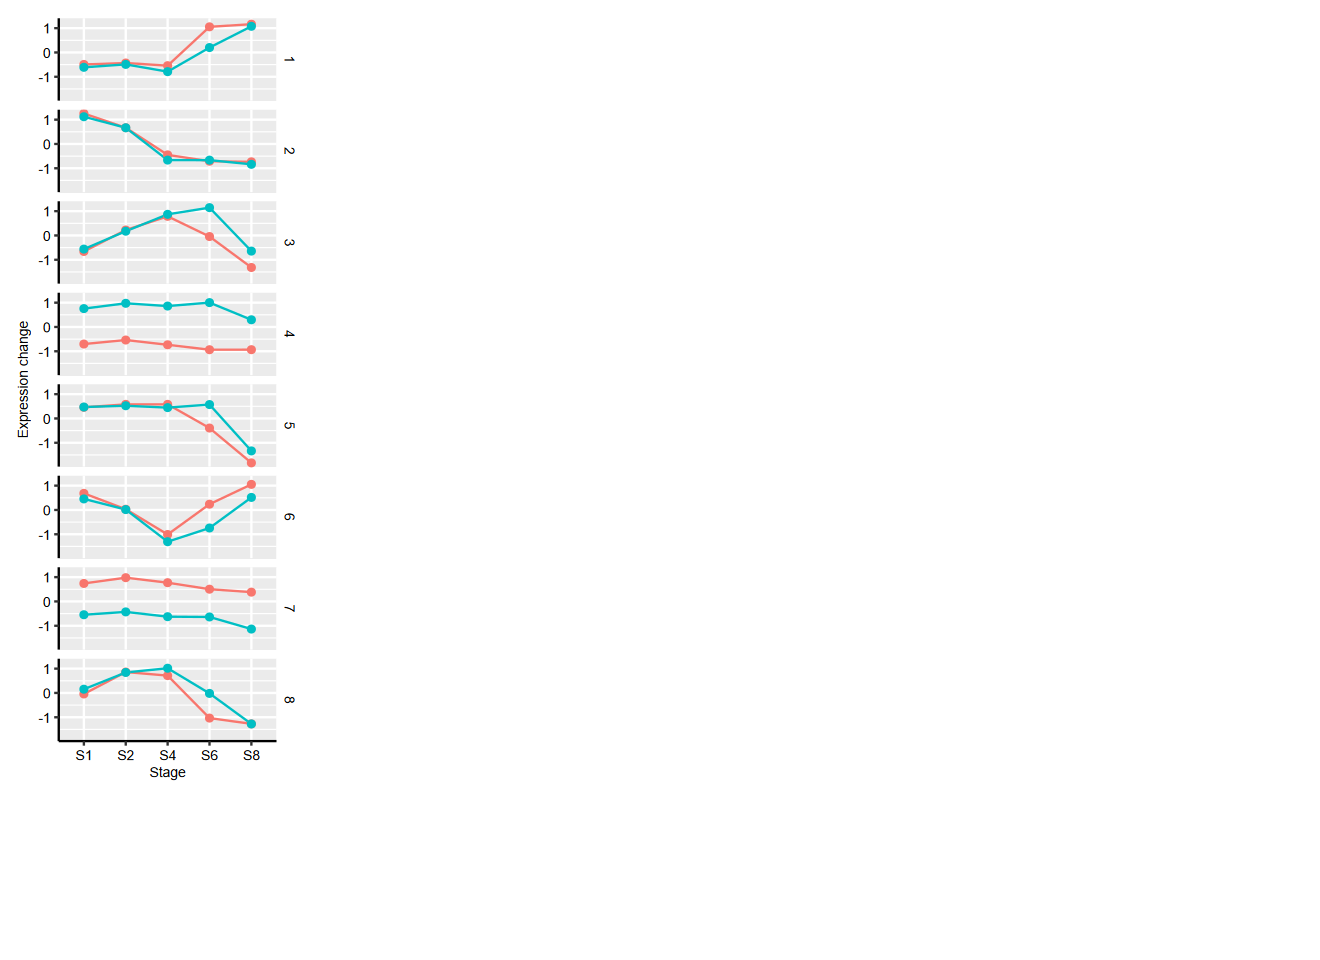

In [75]:
options(repr.plot.width=11, repr.plot.height=8)
(((Figure4A|plot_spacer())+plot_layout(width=c(2,9)))/plot_spacer())+plot_layout(height=c(5,1))

In [76]:
#pdf("Figures\\Figure 4.pdf",width=11,height=8)
#(((Figure4A|plot_spacer())+plot_layout(width=c(2,9)))/plot_spacer())+plot_layout(height=c(5,1))
#dev.off()

pdf 
  2